# Проект решает три задачи маркетингового ML : uplift-моделирование, контактная политика, propensity-моделирование и кластеризация.

***1. Uplift-моделирование:*** построить модель, которая оценивает прирост конверсии (uplift) от отправки предложения конкретному клиенту. Цель — определить клиентов, на которых коммуникация оказывает максимальный положительный эффект, и тем самым оптимизировать бюджет маркетинга.

***2. Контактная политика:*** разработать правила коммуникации: разделить клиентов на группы (например, «Активно», «Стандарт», «Пауза») на основе вероятности покупки и других факторов. Цель — снизить количество неэффективных контактов и повысить лояльность.

***3. Propensity-моделирование и кластеризация:*** построить модель склонности к покупке (propensity to purchase) и сегментировать клиентов с помощью кластеризации. Цель — выявить наиболее «любимые» сегменты с высокой конверсией для приоритетного таргетинга.

<u> **Бизнес-ценность проекта:** </u> <p>
***1.*** Сокращение маркетингового бюджета за счёт отправки предложений только «убеждаемым» клиентам<p>
***2.*** Повышение ROI кампаний<p>
***3.*** Улучшение клиентского опыта благодаря персонализированной коммуникации<p>

<u> **Описание датасета:** </u>
https://www.kaggle.com/datasets/davinwijaya/customer-retention <P>
Набор данных содержит информацию о клиентах розничной компании и их реакции на маркетинговые коммуникации. Каждый клиент получил одно из трёх предложений (или не получил ничего), и зафиксирован результат — совершил ли клиент покупку после предложения.

***recency*** — количество месяцев с момента последней покупки клиента <p>
***history*** — общая сумма покупок клиента за всё время (в долларах)<p>
***used_discount*** — использовал ли клиент скидки в прошлом <p>
***used_bogo*** — использовал ли клиент акции типа «Купи один — получи второй бесплатно» в прошлом<p>
***zip_code*** — почтовый индекс клиента (категориальный признак: Suburban, Urban, Rural)<p>
***is_referral*** — пришёл ли клиент по реферальной программе <p>
***channel*** — канал привлечения клиента (Phone, Web, Multichannel)<p>
***offer*** — тип полученного предложения (Discount, Buy One Get One, No Offer)<p>
***conversion*** — целевая переменная (1 — клиент совершил покупку, 0 — нет)<p>

## Loading and Exploratory Data Analysis (EDA)

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.decomposition import PCA
import optuna
from optuna.samplers import TPESampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [67]:
df = pd.read_csv('data1.csv')
df

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0
...,...,...,...,...,...,...,...,...,...
63995,10,105.54,1,0,Urban,0,Web,Discount,0
63996,5,38.91,0,1,Urban,1,Phone,Discount,0
63997,6,29.99,1,0,Urban,1,Phone,Discount,0
63998,1,552.94,1,0,Surburban,1,Multichannel,Buy One Get One,0


In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   recency           64000 non-null  int64  
 1   history           64000 non-null  float64
 2   used_discount     64000 non-null  int64  
 3   used_bogo         64000 non-null  int64  
 4   zip_code          64000 non-null  object 
 5   is_referral       64000 non-null  int64  
 6   channel           64000 non-null  object 
 7   offer             64000 non-null  object 
 8   conversion        64000 non-null  int64  
 9   history_discount  64000 non-null  float64
 10  history_bogo      64000 non-null  float64
 11  recency_history   64000 non-null  float64
 12  recency_low       64000 non-null  float64
 13  recency_medium    64000 non-null  float64
 14  recency_high      64000 non-null  float64
 15  treatment         64000 non-null  int64  
 16  cluster           64000 non-null  int32 

In [5]:
df.describe()

,recency,history,used_discount,used_bogo,is_referral,conversion
count,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000
mean,5.763734,242.085656,0.551031,0.549719,0.502250,0.146781
std,3.507592,256.158608,0.497393,0.497526,0.499999,0.353890
min,1.000000,29.990000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,64.660000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,158.110000,1.000000,1.000000,1.000000,0.000000
75%,9.000000,325.657500,1.000000,1.000000,1.000000,0.000000
max,12.000000,3345.930000,1.000000,1.000000,1.000000,1.000000


In [6]:
print("Колонки:", df.columns.tolist())

Колонки: ['recency', 'history', 'used_discount', 'used_bogo', 'zip_code', 'is_referral', 'channel', 'offer', 'conversion']


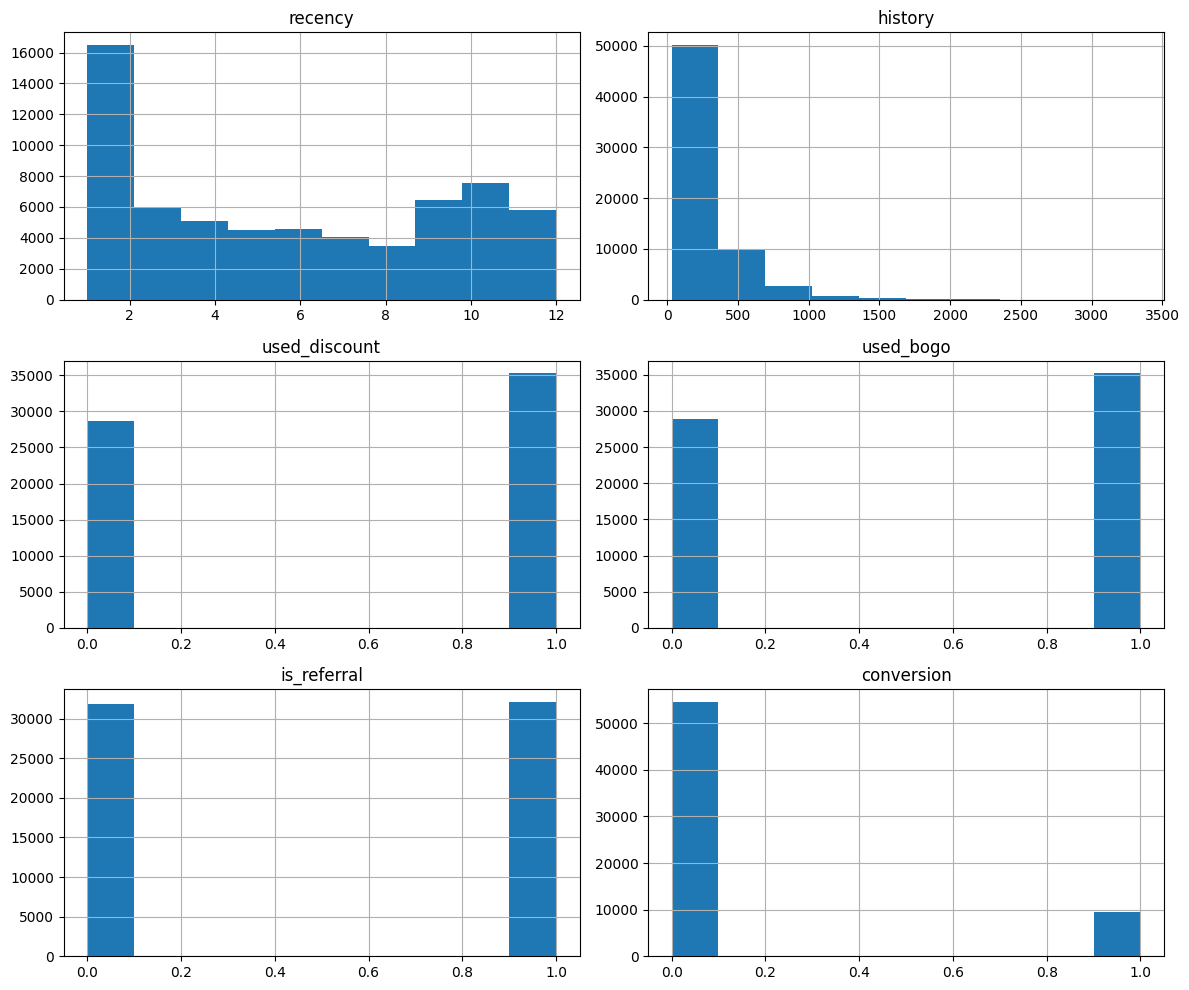

In [7]:

df.hist(figsize=(12, 10))
plt.tight_layout()
plt.show()


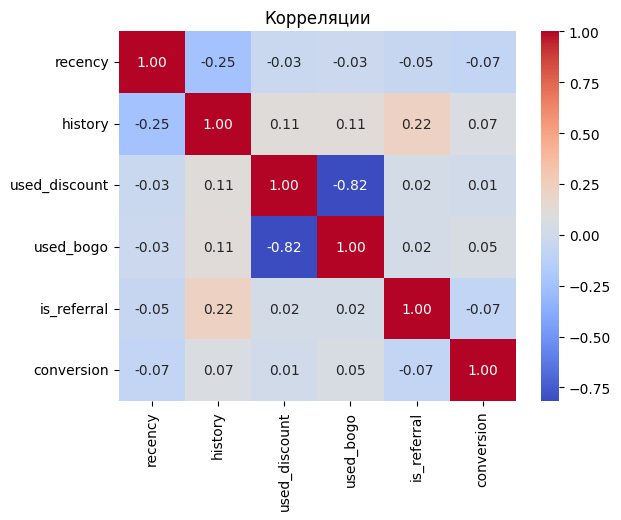

In [8]:
corr = df[['recency', 'history', 'used_discount', 'used_bogo', 'is_referral', 'conversion']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Корреляции')
plt.show()

## Data Preparation and Feature Engineering

In [17]:
df['history_discount'] = df['history'] * df['used_discount']
df['history_bogo'] = df['history'] * df['used_bogo']
df['recency_history'] = df['recency'] * df['history']

In [18]:
kbins = KBinsDiscretizer(n_bins=3, encode='onehot-dense', strategy='quantile')
binned = kbins.fit_transform(df[['recency']])
df[['recency_low', 'recency_medium', 'recency_high']] = binned

In [19]:
df['treatment'] = (df['offer'] != 'No Offer').astype(int)


In [21]:
y = df['conversion']
X = df.drop(columns=['offer', 'conversion', 'treatment'])

categorical_cols = ['zip_code', 'channel', 'is_referral']
numeric_cols = [c for c in X.columns if c not in categorical_cols]

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
])

X_preprocessed = preprocessor.fit_transform(X)
treatment = df['treatment']

## Task 1: Uplift Modeling (Stable X-Learner)

In [22]:
stratify_key = treatment.astype(str) + "_" + y.astype(str)
X_train, X_test, t_train, t_test, y_train, y_test = train_test_split(
    X_preprocessed, treatment, y, test_size=0.2, random_state=42, stratify=stratify_key
)

def auuc_score(y_true, uplift_pred, treatment):
    order = np.argsort(-uplift_pred)
    y_true = np.asarray(y_true)[order]
    treatment = np.asarray(treatment)[order]
    n_treat = treatment.sum()
    n_control = len(treatment) - n_treat
    if n_treat == 0 or n_control == 0:
        return 0.0
    cum_gain_t = np.cumsum(y_true * treatment)
    cum_gain_c = np.cumsum(y_true * (1 - treatment))
    uplift_curve = (cum_gain_t / n_treat) - (cum_gain_c / n_control)
    treated_fraction = np.cumsum(treatment) / n_treat
    return np.trapz(uplift_curve, treated_fraction)

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 5, 20),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'num_leaves': trial.suggest_int('num_leaves', 20, 200),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'random_state': 42,
        'n_jobs': -1
    }
    model = LGBMClassifier(**params)
    model.fit(X_train[t_train == 1], y_train[t_train == 1])
    pred = model.predict_proba(X_test[t_test == 1])[:, 1]
    return roc_auc_score(y_test[t_test == 1], pred)


In [23]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

[I 2025-12-28 20:22:22,082] A new study created in memory with name: no-name-e898f4d5-fd5f-4cbb-ae23-318d986e5787


[LightGBM] [Info] Number of positive: 5706, number of negative: 28449
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000653 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1064
[LightGBM] [Info] Number of data points in the train set: 34155, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.167062 -> initscore=-1.606595
[LightGBM] [Info] Start training from score -1.606595
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2025-12-28 20:22:24,401] Trial 0 finished with value: 0.5656404359282108 and parameters: {'n_estimators': 228, 'max_depth': 15, 'learning_rate': 0.11288356709165993, 'num_leaves': 110, 'min_child_samples': 52}. Best is trial 0 with value: 0.5656404359282108.


[LightGBM] [Info] Number of positive: 5706, number of negative: 28449
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000367 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1064
[LightGBM] [Info] Number of data points in the train set: 34155, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.167062 -> initscore=-1.606595
[LightGBM] [Info] Start training from score -1.606595
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-28 20:22:25,068] Trial 1 finished with value: 0.587570976555776 and parameters: {'n_estimators': 250, 'max_depth': 6, 'learning_rate': 0.16634730548775006, 'num_leaves': 42, 'min_child_samples': 82}. Best is trial 1 with value: 0.587570976555776.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-28 20:22:27,959] Trial 2 finished with value: 0.5623923286856592 and parameters: {'n_estimators': 403, 'max_depth': 13, 'learning_rate': 0.1385776342692221, 'num_leaves': 187, 'min_child_samples': 76}. Best is trial 1 with value: 0.587570976555776.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 5706, number of negative: 28449
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000408 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is n

[I 2025-12-28 20:22:28,598] Trial 3 finished with value: 0.605142116768992 and parameters: {'n_estimators': 206, 'max_depth': 6, 'learning_rate': 0.07022254014462237, 'num_leaves': 66, 'min_child_samples': 98}. Best is trial 3 with value: 0.605142116768992.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-28 20:22:32,041] Trial 4 finished with value: 0.5466166880505815 and parameters: {'n_estimators': 368, 'max_depth': 8, 'learning_rate': 0.1579492572342508, 'num_leaves': 133, 'min_child_samples': 7}. Best is trial 3 with value: 0.605142116768992.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-28 20:22:35,948] Trial 5 finished with value: 0.5662156031003422 and parameters: {'n_estimators': 422, 'max_depth': 15, 'learning_rate': 0.07179871451369171, 'num_leaves': 124, 'min_child_samples': 61}. Best is trial 3 with value: 0.605142116768992.


[LightGBM] [Info] Number of positive: 5706, number of negative: 28449
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000373 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1064
[LightGBM] [Info] Number of data points in the train set: 34155, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.167062 -> initscore=-1.606595
[LightGBM] [Info] Start training from score -1.606595
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-28 20:22:38,107] Trial 6 finished with value: 0.5601674255048092 and parameters: {'n_estimators': 266, 'max_depth': 11, 'learning_rate': 0.15086134880173965, 'num_leaves': 93, 'min_child_samples': 31}. Best is trial 3 with value: 0.605142116768992.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 5706, number of negative: 28449
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000416 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is n

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-28 20:22:39,645] Trial 7 finished with value: 0.572583898592329 and parameters: {'n_estimators': 282, 'max_depth': 10, 'learning_rate': 0.12717194068894316, 'num_leaves': 79, 'min_child_samples': 75}. Best is trial 3 with value: 0.605142116768992.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-28 20:22:41,798] Trial 8 finished with value: 0.5563116660741478 and parameters: {'n_estimators': 341, 'max_depth': 12, 'learning_rate': 0.13985077580477337, 'num_leaves': 57, 'min_child_samples': 9}. Best is trial 3 with value: 0.605142116768992.


[LightGBM] [Info] Number of positive: 5706, number of negative: 28449
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000371 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1064
[LightGBM] [Info] Number of data points in the train set: 34155, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.167062 -> initscore=-1.606595
[LightGBM] [Info] Start training from score -1.606595
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-28 20:22:45,348] Trial 9 finished with value: 0.5561919792474478 and parameters: {'n_estimators': 446, 'max_depth': 13, 'learning_rate': 0.17816105653806555, 'num_leaves': 96, 'min_child_samples': 54}. Best is trial 3 with value: 0.605142116768992.


[LightGBM] [Info] Number of positive: 5706, number of negative: 28449
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000370 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1064
[LightGBM] [Info] Number of data points in the train set: 34155, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.167062 -> initscore=-1.606595
[LightGBM] [Info] Start training from score -1.606595


[I 2025-12-28 20:22:45,809] Trial 10 finished with value: 0.6225978587691501 and parameters: {'n_estimators': 112, 'max_depth': 20, 'learning_rate': 0.02189998730132303, 'num_leaves': 29, 'min_child_samples': 94}. Best is trial 10 with value: 0.6225978587691501.


[LightGBM] [Info] Number of positive: 5706, number of negative: 28449
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000388 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1064
[LightGBM] [Info] Number of data points in the train set: 34155, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.167062 -> initscore=-1.606595
[LightGBM] [Info] Start training from score -1.606595


[I 2025-12-28 20:22:46,144] Trial 11 finished with value: 0.6252393490061952 and parameters: {'n_estimators': 106, 'max_depth': 19, 'learning_rate': 0.013458480036797567, 'num_leaves': 21, 'min_child_samples': 98}. Best is trial 11 with value: 0.6252393490061952.


[LightGBM] [Info] Number of positive: 5706, number of negative: 28449
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000371 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1064
[LightGBM] [Info] Number of data points in the train set: 34155, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.167062 -> initscore=-1.606595
[LightGBM] [Info] Start training from score -1.606595


[I 2025-12-28 20:22:46,485] Trial 12 finished with value: 0.6239053929858787 and parameters: {'n_estimators': 107, 'max_depth': 20, 'learning_rate': 0.010936330221306257, 'num_leaves': 21, 'min_child_samples': 94}. Best is trial 11 with value: 0.6252393490061952.


[LightGBM] [Info] Number of positive: 5706, number of negative: 28449
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000392 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1064
[LightGBM] [Info] Number of data points in the train set: 34155, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.167062 -> initscore=-1.606595
[LightGBM] [Info] Start training from score -1.606595


[I 2025-12-28 20:22:46,840] Trial 13 finished with value: 0.6247780519204215 and parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.01558791471040831, 'num_leaves': 24, 'min_child_samples': 98}. Best is trial 11 with value: 0.6252393490061952.


[LightGBM] [Info] Number of positive: 5706, number of negative: 28449
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000391 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1064
[LightGBM] [Info] Number of data points in the train set: 34155, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.167062 -> initscore=-1.606595
[LightGBM] [Info] Start training from score -1.606595
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2025-12-28 20:22:49,441] Trial 14 finished with value: 0.5841293394608256 and parameters: {'n_estimators': 181, 'max_depth': 18, 'learning_rate': 0.04315222159451018, 'num_leaves': 161, 'min_child_samples': 83}. Best is trial 11 with value: 0.6252393490061952.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 5706, number of negative: 28449
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000384 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1064
[LightGBM] [Info] Number of data points in the train set: 34155, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.167062 -> initscore=-1.606595
[LightGBM] [Info] Start training from score -1.606595


[I 2025-12-28 20:22:50,356] Trial 15 finished with value: 0.604230219484345 and parameters: {'n_estimators': 158, 'max_depth': 17, 'learning_rate': 0.04852161655540296, 'num_leaves': 47, 'min_child_samples': 66}. Best is trial 11 with value: 0.6252393490061952.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 5706, number of negative: 28449
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000385 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1064
[LightGBM] [Info] Number of data points in the train set: 34155, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.167062 -> initscore=-1.606595
[LightGBM] [Info] Start training from score -1.606595


[I 2025-12-28 20:22:50,878] Trial 16 finished with value: 0.6038861937991971 and parameters: {'n_estimators': 167, 'max_depth': 18, 'learning_rate': 0.08793633313993224, 'num_leaves': 24, 'min_child_samples': 42}. Best is trial 11 with value: 0.6252393490061952.


[LightGBM] [Info] Number of positive: 5706, number of negative: 28449
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000388 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1064
[LightGBM] [Info] Number of data points in the train set: 34155, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.167062 -> initscore=-1.606595
[LightGBM] [Info] Start training from score -1.606595
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-12-28 20:22:54,391] Trial 17 finished with value: 0.5836757815973715 and parameters: {'n_estimators': 491, 'max_depth': 16, 'learning_rate': 0.03468661801012317, 'num_leaves': 70, 'min_child_samples': 100}. Best is trial 11 with value: 0.6252393490061952.


[LightGBM] [Info] Number of positive: 5706, number of negative: 28449
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000386 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1064
[LightGBM] [Info] Number of data points in the train set: 34155, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.167062 -> initscore=-1.606595
[LightGBM] [Info] Start training from score -1.606595
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-12-28 20:22:55,072] Trial 18 finished with value: 0.58022206737205 and parameters: {'n_estimators': 134, 'max_depth': 19, 'learning_rate': 0.19920249565536108, 'num_leaves': 41, 'min_child_samples': 85}. Best is trial 11 with value: 0.6252393490061952.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 5706, number of negative: 28449
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000438 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1064
[LightGBM] [Info] Number of data points in the train set: 34155, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.167062 -> initscore=-1.606595
[LightGBM] [Info] Start training from score -1.606595
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2025-12-28 20:22:59,940] Trial 19 finished with value: 0.5620017690777745 and parameters: {'n_estimators': 315, 'max_depth': 20, 'learning_rate': 0.05681214192719571, 'num_leaves': 152, 'min_child_samples': 30}. Best is trial 11 with value: 0.6252393490061952.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [26]:
best_params = study.best_params
best_params

{'n_estimators': 106,
 'max_depth': 19,
 'learning_rate': 0.013458480036797567,
 'num_leaves': 21,
 'min_child_samples': 98}

In [27]:
best_params.update({'random_state': 42, 'n_jobs': -1})

In [29]:
effect_params = best_params.copy()
effect_params

{'n_estimators': 106,
 'max_depth': 19,
 'learning_rate': 0.013458480036797567,
 'num_leaves': 21,
 'min_child_samples': 98,
 'random_state': 42,
 'n_jobs': -1}

In [31]:
effect_params.update({'reg_alpha': 5.0, 'reg_lambda': 5.0, 'min_child_weight': 10})
effect_params

{'n_estimators': 106,
 'max_depth': 19,
 'learning_rate': 0.013458480036797567,
 'num_leaves': 21,
 'min_child_samples': 98,
 'random_state': 42,
 'n_jobs': -1,
 'reg_alpha': 5.0,
 'reg_lambda': 5.0,
 'min_child_weight': 10}

In [32]:
prop_model = LGBMClassifier(**best_params)
prop_model.fit(X_train, t_train)


[LightGBM] [Info] Number of positive: 34155, number of negative: 17045
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000992 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1064
[LightGBM] [Info] Number of data points in the train set: 51200, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.667090 -> initscore=0.695052
[LightGBM] [Info] Start training from score 0.695052


LGBMClassifier(learning_rate=0.013458480036797567, max_depth=19,
               min_child_samples=98, n_estimators=106, n_jobs=-1, num_leaves=21,
               random_state=42)

In [33]:
prop_score_test = prop_model.predict_proba(X_test)[:, 1]

In [34]:
outcome_t = LGBMClassifier(**best_params)
outcome_c = LGBMClassifier(**best_params)
outcome_t.fit(X_train[t_train == 1], y_train[t_train == 1])
outcome_c.fit(X_train[t_train == 0], y_train[t_train == 0])

[LightGBM] [Info] Number of positive: 5706, number of negative: 28449
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000738 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1064
[LightGBM] [Info] Number of data points in the train set: 34155, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.167062 -> initscore=-1.606595
[LightGBM] [Info] Start training from score -1.606595
[LightGBM] [Info] Number of positive: 1810, number of negative: 15235
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000232 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1064
[LightGBM] [Info] Number of data points in the train set: 17045, number of used features: 18
[LightGBM] [Info] [b

LGBMClassifier(learning_rate=0.013458480036797567, max_depth=19,
               min_child_samples=98, n_estimators=106, n_jobs=-1, num_leaves=21,
               random_state=42)

In [38]:
pseudo_t = y_train[t_train == 1] - outcome_c.predict_proba(X_train[t_train == 1])[:, 1]
pseudo_c = outcome_t.predict_proba(X_train[t_train == 0])[:, 1] - y_train[t_train == 0]

In [40]:
effect_t = LGBMRegressor(**effect_params)
effect_t.fit(X_train[t_train == 1], pseudo_t)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000568 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1064
[LightGBM] [Info] Number of data points in the train set: 34155, number of used features: 18
[LightGBM] [Info] Start training from score 0.060591


LGBMRegressor(learning_rate=0.013458480036797567, max_depth=19,
              min_child_samples=98, min_child_weight=10, n_estimators=106,
              n_jobs=-1, num_leaves=21, random_state=42, reg_alpha=5.0,
              reg_lambda=5.0)

In [41]:
effect_c = LGBMRegressor(**effect_params)
effect_c.fit(X_train[t_train == 0], pseudo_c)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000341 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1064
[LightGBM] [Info] Number of data points in the train set: 17045, number of used features: 18
[LightGBM] [Info] Start training from score 0.060584


LGBMRegressor(learning_rate=0.013458480036797567, max_depth=19,
              min_child_samples=98, min_child_weight=10, n_estimators=106,
              n_jobs=-1, num_leaves=21, random_state=42, reg_alpha=5.0,
              reg_lambda=5.0)

In [42]:
uplift_raw = prop_score_test * effect_t.predict(X_test) + (1 - prop_score_test) * effect_c.predict(X_test)
uplift_pred = np.clip(uplift_raw, -0.15, 0.30)

In [43]:
auuc = auuc_score(y_test, uplift_pred, t_test)
print(f"AUUC: {auuc:.5f}")

AUUC: 0.03342


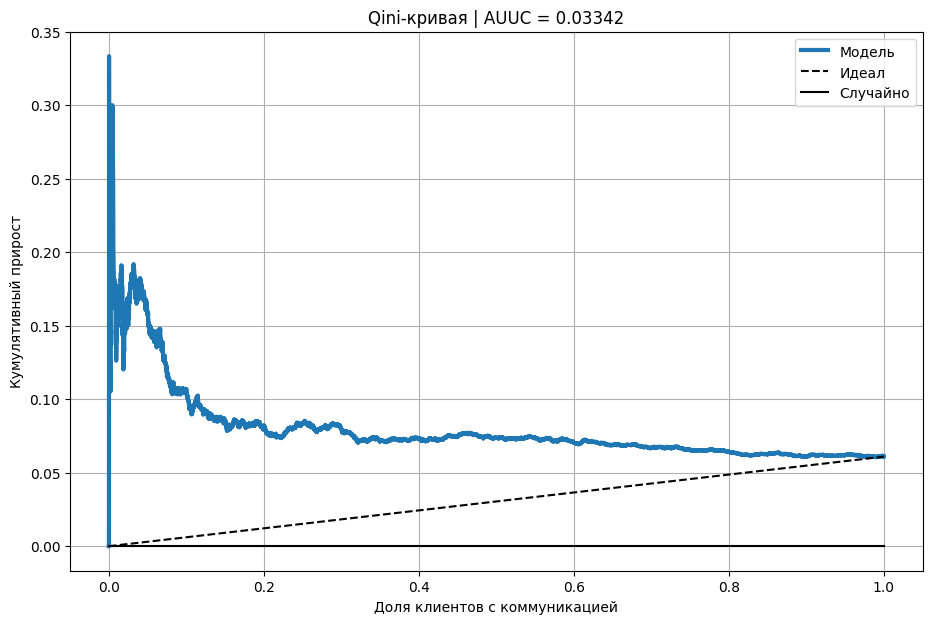

In [45]:
# Qini-кривая (стандартная)
order = np.argsort(-uplift_pred)
y_sorted = np.asarray(y_test)[order]
t_sorted = np.asarray(t_test)[order]

cum_treated = np.cumsum(t_sorted)
cum_control = np.cumsum(1 - t_sorted)
cum_response_t = np.cumsum(y_sorted * t_sorted) / np.maximum(cum_treated, 1)
cum_response_c = np.cumsum(y_sorted * (1 - t_sorted)) / np.maximum(cum_control, 1)
cum_uplift = cum_response_t - cum_response_c
treated_fraction = cum_treated / cum_treated[-1] if cum_treated[-1] > 0 else np.zeros(len(cum_uplift))

plt.figure(figsize=(11, 7))
plt.plot(treated_fraction, cum_uplift, label='Модель', linewidth=3)
plt.plot([0, 1], [0, cum_uplift[-1]], 'k--', label='Идеал')
plt.plot([0, 1], [0, 0], 'k-', label='Случайно')
plt.title(f'Qini-кривая | AUUC = {auuc:.5f}')
plt.xlabel('Доля клиентов с коммуникацией')
plt.ylabel('Кумулятивный прирост')
plt.legend()
plt.grid()
plt.show()



## Top Customers Identification and Analysis by Uplift

In [47]:
# --- Выделение топ-клиентов ---
top_percent = 1.0  # Измените на нужный процент (0.5, 2.0, 5.0)
top_n = int(len(uplift_pred) * (top_percent / 100))

top_indices_test = np.argsort(-uplift_pred)[:top_n]

print(f"\nТоп {top_percent}% клиентов по uplift ({top_n} человек)")
print(f"Средний uplift: {uplift_pred[top_indices_test].mean():.4f}")
print(f"Конверсия в топе: {y_test.iloc[top_indices_test].mean():.4f} (vs общая: {y_test.mean():.4f})")



Топ 1.0% клиентов по uplift (128 человек)
Средний uplift: 0.1165
Конверсия в топе: 0.1719 (vs общая: 0.1467)


In [48]:
# Профиль
original_test_indices = y_test.index[top_indices_test]
top_clients_df = df.loc[original_test_indices].copy()
top_clients_df['uplift_score'] = uplift_pred[top_indices_test]

compare_cols = ['recency', 'history', 'used_discount', 'used_bogo', 'is_referral']
print("\nПрофиль топ-клиентов (среднее):")
print(top_clients_df[compare_cols].mean().round(2))

print("\nСреднее по всей базе:")
print(df[compare_cols].mean().round(2))

# Сохранение
top_clients_df.to_csv('top_clients_by_uplift.csv', index=False)
print(f"\nТоп-клиенты сохранены в 'top_clients_by_uplift.csv'")


Профиль топ-клиентов (среднее):
recency            6.25
history          236.32
used_discount      1.00
used_bogo          0.95
is_referral        0.70
dtype: float64

Среднее по всей базе:
recency            5.76
history          242.09
used_discount      0.55
used_bogo          0.55
is_referral        0.50
dtype: float64

Топ-клиенты сохранены в 'top_clients_by_uplift.csv'


## Feature Importance


Топ-10 важных признаков:
                  feature  importance
6    num__recency_history         344
0            num__recency         332
1            num__history         252
5       num__history_bogo         217
16     cat__is_referral_0         209
15       cat__channel_Web         199
10    cat__zip_code_Rural         178
2      num__used_discount         127
4   num__history_discount         122
3          num__used_bogo          50


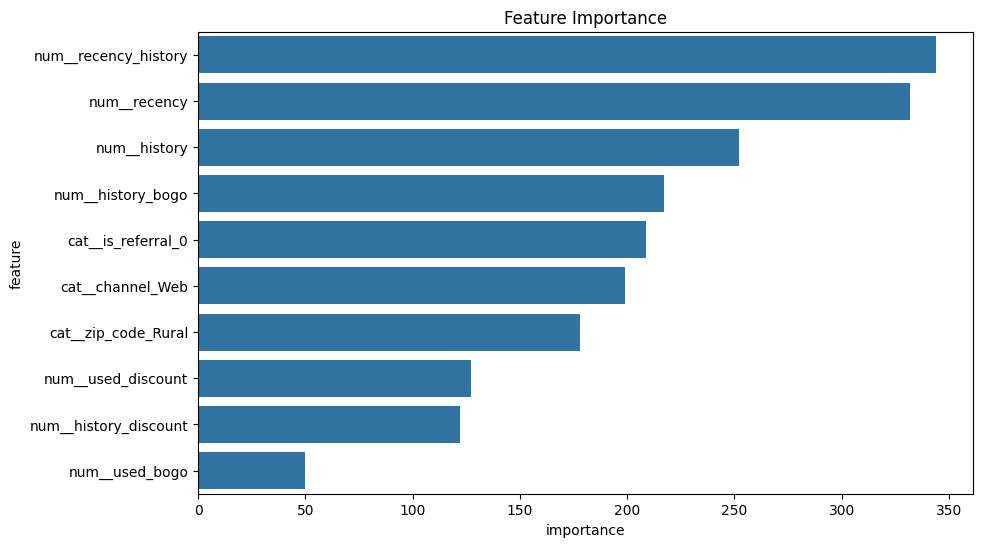

In [49]:
feature_names = preprocessor.get_feature_names_out()
importance = outcome_t.feature_importances_

imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importance
}).sort_values('importance', ascending=False)

print("\nТоп-10 важных признаков:")
print(imp_df.head(10).round(4))

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=imp_df.head(10))
plt.title('Feature Importance')
plt.show()

## Task 2: Contact Policy and ROI Simulation

In [50]:
# Контактная политика
policy_model = RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1)
policy_model.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)

In [51]:
probs = policy_model.predict_proba(X_preprocessed)[:, 1]
policy = np.where(probs > 0.15, 'Активно', np.where(probs < 0.05, 'Пауза', 'Стандарт'))

print("\nКонтактная политика:")
for p, c in zip(*np.unique(policy, return_counts=True)):
    print(f"{p}: {c:,} ({c/len(policy):.1%})")



Контактная политика:
Активно: 21,388 (33.4%)
Пауза: 30,900 (48.3%)
Стандарт: 11,712 (18.3%)


In [52]:
# ROI симуляция
cost_per_contact = 5
profit_per_conversion = 2000

baseline_conversions = y_test.sum()
baseline_cost = len(t_test) * cost_per_contact
baseline_profit = baseline_conversions * profit_per_conversion

top_10_n = int(len(uplift_pred) * 0.1)
top_10_idx = np.argsort(-uplift_pred)[:top_10_n]
uplift_conversions = y_test.iloc[top_10_idx].sum()
uplift_cost = top_10_n * cost_per_contact
uplift_profit = uplift_conversions * profit_per_conversion

print("\nROI симуляция:")
print(f"Базлайн (всем): конверсий {baseline_conversions}, затраты {baseline_cost:,} руб")
print(f"Uplift (топ 10%): конверсий {uplift_conversions}, затраты {uplift_cost:,} руб")
print(f"ROI uplift в {(uplift_profit - uplift_cost) / uplift_cost:.1%} vs базлайн")


ROI симуляция:
Базлайн (всем): конверсий 1878, затраты 64,000 руб
Uplift (топ 10%): конверсий 265, затраты 6,400 руб
ROI uplift в 8181.2% vs базлайн


## Task 3: Propensity Modeling and Customer Clustering

In [53]:
prop_model = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
prop_model.fit(X_train, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [54]:
prop_scores = prop_model.predict_proba(X_test)[:, 1]
print(f"Средняя propensity: {prop_scores.mean():.4f}")

Средняя propensity: 0.4820


In [55]:
kmeans = KMeans(n_clusters=5, random_state=42, n_init='auto')
kmeans.fit(X_train)

KMeans(n_clusters=5, random_state=42)

In [56]:
df['cluster'] = kmeans.predict(X_preprocessed)

In [57]:
print("\nConversion по кластерам:")
print(
    df.groupby('cluster')['conversion'].mean().sort_values(
        ascending=False).round(4))


Conversion по кластерам:
cluster
4    0.2122
1    0.1786
2    0.1434
0    0.1196
3    0.1119
Name: conversion, dtype: float64


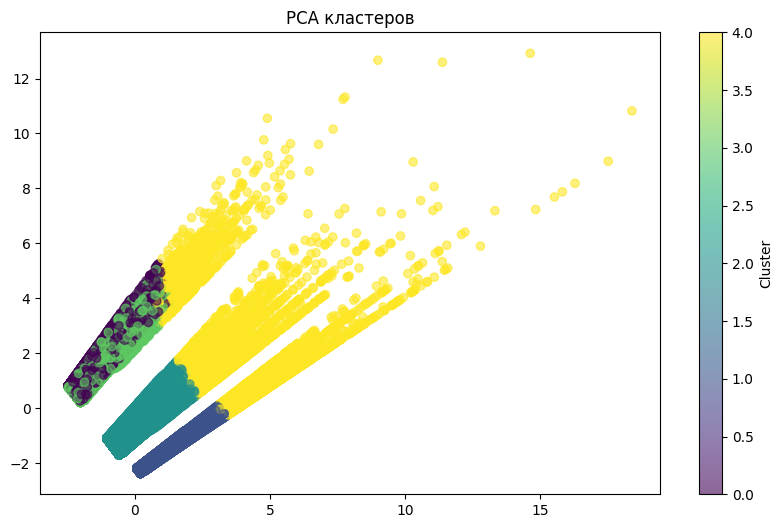

In [58]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_preprocessed)
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['cluster'], cmap='viridis', alpha=0.6)
plt.title('PCA кластеров')
plt.colorbar(label='Cluster')
plt.show()